Markov state model for penta peptide
=====


In [1]:
import pyemma
pyemma.__version__

'1.2-451-g7302ed6-dirty'

This notebook has been tested for version 1.2.1. If you are using a different version some adaptations may be required.

Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [303]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the pyEMMA modules required later

In [337]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

WW-pentapeptide - load data
------

We first have to load the PDB file and the trajectory data, in this case for WW-pentapeptide.

In [4]:
indir = './data'
topfile =  indir+'/init-ww-penta.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which coordinates we would like to use in the further analysis. In this case simply the cartesian coordinates.

In [5]:
feat = coor.featurizer(topfile)
# just use all xyz-coordinates
feat.add_backbone_torsions()
#feat.add_backbone_torsions(cossin=True)
feat.describe()

['PHI 0 LEU 2 ',
 'PHI 0 ALA 3 ',
 'PHI 0 LEU 4 ',
 'PHI 0 LEU 5 ',
 'PSI 0 LEU 2 ',
 'PSI 0 ALA 3 ',
 'PSI 0 LEU 4 ',
 'PSI 0 LEU 5 ']

Now we load the coordinates and check the number of dimensions:

In [140]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

number of trajectories =  25
trajectory length =  10001
number of dimension =  8


These initial coordinates need to be transformed into sines and cosines (workaround, to be replaced by cossin option).

In [141]:
config['show_progress_bars']=False # no progress bars wanted here
stack_traj = []
for i in range(len(traj_list)):
    X = coor.load(traj_list[i], feat)
    cY=np.hstack((np.cos(X),np.sin(X)))
    stack_traj.append(cY)
st_traj = np.array(stack_traj)

In [142]:
# reduce trajectories
stack_traj = [traj[::2] for traj in stack_traj]
st_traj = np.array(stack_traj)

Check the properties of the new dataset:

In [143]:
print 'number of trajectories = ',st_traj.shape[0]
print 'trajectory length = ',st_traj.shape[1]
print 'number of dimensions = ',st_traj.shape[2]

number of trajectories =  25
trajectory length =  5001
number of dimensions =  16


#TICA and clustering 

In [149]:
# FN: I changed the lag time from 1000 to 30. I think you didn't change this after reducing the data. 1000 is far
# longer than any timescale, resulting in random TICA directions. Surprising it still worked well.
config['show_progress_bars']=True # progress bars can be activated again for this part
tica_lag = 15      # tica lagtime
# FN: Dimension is no longer needed, because we have automatic selection below
# tica_dim = 2 # tica dimensions

In [150]:
# FN: do TICA with 95% kinetic variance
tica_obj = coor.tica(stack_traj, lag=tica_lag, kinetic_map=True, var_cutoff=0.95)#, dim=tica_dim)

2015-07-19 14:59:32,169 coordinates.transform.TICA[82] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-19 14:59:32,170 coordinates.transform.TICA[82] INFO     Running TICA with tau=15; Estimating two covariance matrices with dimension (16, 16)


In [151]:
# Nice separation: we get 98.7% of the kinetic variance with three dimensions - the rest is irrelevant.
tica_obj.cumvar

array([ 0.42157529,  0.78310013,  0.98679394,  0.99650128,  0.99990955,
        0.999969  ,  0.99999993,  1.        ])

In [202]:
Y = tica_obj.get_output() # get tica coordinates

In [153]:
# three significant eigenvalues
tica_obj.eigenvalues

array([  7.29300730e-01,   6.75364375e-01,   5.06941662e-01,
         1.10667297e-01,   6.55745999e-02,   8.66054002e-03,
        -6.24688542e-03,   3.01063697e-04])

Now we look at the distribution on the two dominant TICA coordinates

/Users/noe/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


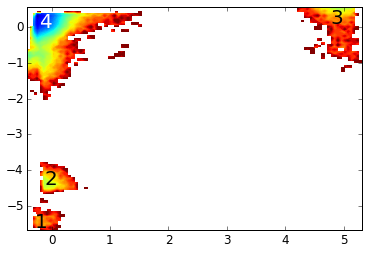

In [325]:
npY = np.array(Y)
npYc = np.concatenate(npY)
# histogram data
z,x,y = np.histogram2d(npYc[:,0],npYc[:,1], bins=100)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 100, extent=extent)
text(-0.25, -5.6, '1', fontsize=20, color='black')
text(-0.1, -4.4, '2', fontsize=20, color='black')
text(4.8, 0.1, '3', fontsize=20, color='black')
text(-0.2, 0, '4', fontsize=20, color='white')
savefig('./figs/free_energy_count.png')

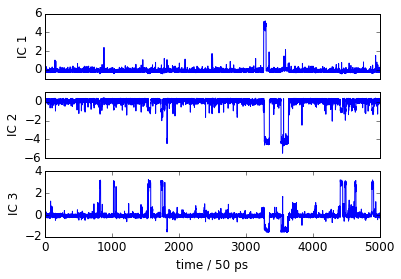

In [344]:
ax1=plt.subplot(311)
plot(Y[0][:,0]); ylabel('IC 1'); xticks([]); yticks([0,2,4,6])
ax1=plt.subplot(312)
plot(Y[0][:,1]); ylabel('IC 2'); xticks([]); yticks([-6, -4, -2, 0])
ax1=plt.subplot(313)
plot(Y[0][:,2]); xlabel('time / 50 ps'); ylabel('IC 3'); yticks([-2,0,2,4])
savefig('./figs/traj_ic.png')

In [156]:
n_clusters = 100      # number of k-means clusters
cl_metric = 'euclidean' # clustering metric

In [157]:
clustering = coor.cluster_kmeans(Y,k=n_clusters)

2015-07-19 14:59:52,813 coordinates.clustering.KmeansClustering[84] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-19 14:59:53,609 coordinates.clustering.KmeansClustering[84] INFO     Accumulated all data, running kmeans on (125025, 3)
2015-07-19 14:59:54,510 coordinates.clustering.KmeansClustering[84] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [158]:
dtrajs = coor.assign_to_centers(Y, centers=clustering.clustercenters, stride=1, return_dtrajs=True, metric=cl_metric)

2015-07-19 14:59:55,857 coordinates.clustering.AssignCenters[86] INFO     reset (previous) parametrization state, since data producer has been changed.


In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories.

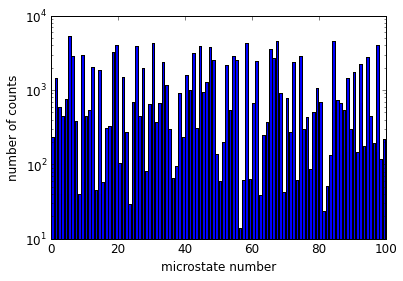

In [295]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram, log=True)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

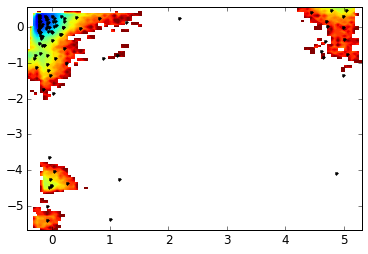

In [304]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
contourf(F.T, 100, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='.', color='black')

The states are well distributed in phase space.

#Implied timescales

In [163]:
its = msm.timescales_msm(dtrajs, lags=100, nits=5, errors='bayes')

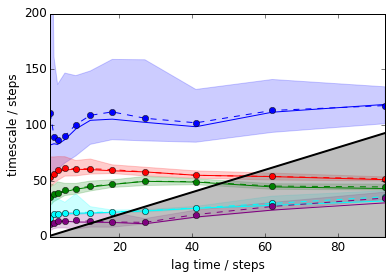

In [345]:
mpl.plot_implied_timescales(its, ylog=False)
ylim(0, 200)
savefig('./figs/its.png')

In [20]:
#its_err = msm.timescales_msm(dtrajs,lags=lags,nits=5,errors='bayes')

In [21]:
#mpl.plot_implied_timescales(its_err)

# Estimate MSM

In [166]:
M = msm.bayesian_markov_model(dtrajs, 20)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


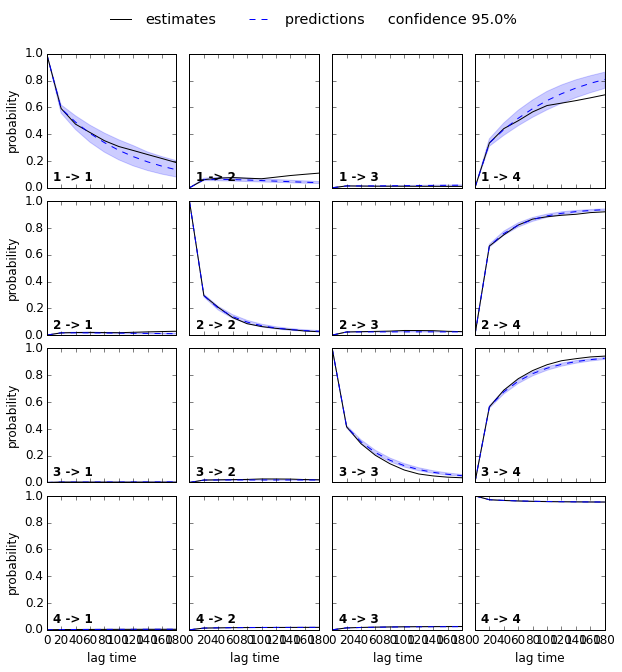

In [346]:
# validate
cktest = M.cktest(4)
mpl.plot_cktest(cktest);
savefig('./figs/cktest.png')

From the Markov state model which is now stored in the object we called *M* various properties can be obtained. We start by analyzing the stationary distribution.

In [169]:
pi = M.stationary_distribution # stationary distribution
F_pi = -np.log(pi)  # free energy based on stationary distribution

In [221]:
from scipy.interpolate import griddata as gd
gd()

In [269]:
def mycontour(x, y, z, ncontours = 50, colorbar=True, fig=None, ax=None, method='linear', zlim=None, cmap=None, outfile=None):
    from scipy.interpolate import griddata as gd
    # check input
    if (ax is None):
        if fig is None:
            ax = plt.gca()
        else:
            ax = fig.gca()

    # grid data
    points = np.hstack([x[:,None],y[:,None]])
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = gd(points, z, (xi, yi), method=method)
    # contour level levels
    if zlim is None:
        zlim = (z.min(), z.max())
    eps = (zlim[1] - zlim[0]) / float(ncontours)
    levels = np.linspace(zlim[0] - eps, zlim[1] + eps)
    # contour plot
    if cmap is None:
        cmap=plt.cm.jet
    cf = ax.contourf(xi, yi, zi, ncontours, cmap=cmap, levels=levels)
    # color bar if requested
    if colorbar:
        plt.colorbar(cf, ax=ax)
    # scatter points
    # ax.scatter(x,y,marker='o',c='b',s=5)    
    return ax

In [260]:
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())
# compute free energies
Fall = -np.log(W)
Fall -= np.min(Fall)

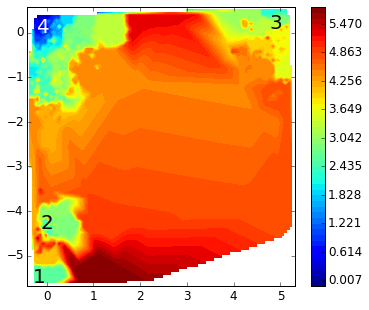

In [327]:
#fig = plt.figure(figsize=(16,5))
#matplotlib.rcParams.update({'font.size': 12})
#ax1=plt.subplot(121)
#ax1.set_title('Stationary distribution')
#mycontour(xall, yall, W)

fig = plt.figure(figsize=(6,5))
#ax2=plt.subplot(122)
#ax2.set_title('Free energy')
mycontour(xall, yall, Fall)
text(-0.25, -5.6, '1', fontsize=20, color='black')
text(-0.1, -4.4, '2', fontsize=20, color='black')
text(4.8, 0.1, '3', fontsize=20, color='black')
text(-0.2, 0, '4', fontsize=20, color='white')
savefig('./figs/free_energy_msm.png')

In [244]:
# project eigenvectors
proj_ev1_all = np.hstack([M.eigenvectors_right()[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
proj_ev2_all = np.hstack([M.eigenvectors_right()[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
proj_ev3_all = np.hstack([M.eigenvectors_right()[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

Now we analyze the slowest processes by looking at the distribution of states along the first 3 eigenvectors.

In [331]:
def printlabels():
    text(-0.25, -5.6, '1', fontsize=20, color='white')
    text(-0.1, -4.4, '2', fontsize=20, color='white')
    text(4.8, 0.1, '3', fontsize=20, color='white')
    text(-0.2, 0, '4', fontsize=20, color='white')

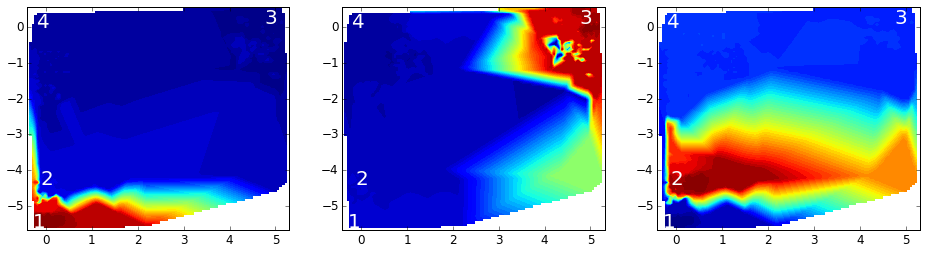

In [332]:
fig = plt.figure(figsize=(16,4))

ax1=plt.subplot(131)
r2 = M.eigenvectors_right()[:,1]
ax1 = mycontour(xall, yall, proj_ev1_all, method='linear', colorbar=False)
printlabels()

ax2=plt.subplot(132)
r3 = M.eigenvectors_right()[:,2]
ax2 = mycontour(xall, yall, proj_ev2_all, method='linear', colorbar=False)
printlabels()

ax3=plt.subplot(133)
r4 = M.eigenvectors_right()[:,3]
ax3 = mycontour(xall, yall, -proj_ev3_all, method='linear', colorbar=False)
printlabels()
savefig('./figs/eigenvectors.png')

Next the MSM is coarse grained into a user-defined number of macrostates (*n_sets*).

In [334]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships
# memberships over trajectory
mem1_all = np.hstack([membership[:,0][dtraj] for dtraj in M.discrete_trajectories_full])
mem2_all = np.hstack([membership[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
mem3_all = np.hstack([membership[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
mem4_all = np.hstack([membership[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

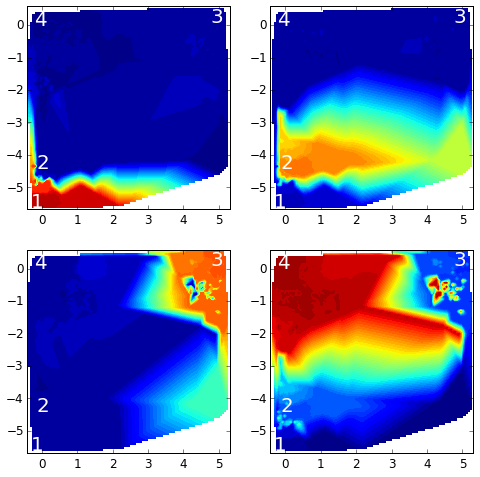

In [335]:
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(221)
ax1 = mycontour(xall, yall, mem1_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()

ax2 = plt.subplot(222)
ax2 = mycontour(xall, yall, mem2_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()

ax3 = plt.subplot(223)
ax3 = mycontour(xall, yall, mem3_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()

ax4 = plt.subplot(224)
ax4 = mycontour(xall, yall, mem4_all, zlim=[0,1], method='linear', colorbar=False)
printlabels()
savefig('./figs/pcca_dists.png')

In [275]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

In [276]:
# you can do this in one command
coor.save_trajs(inp, pcca_samples, outfiles=['./data/pcca1_10samples.xtc','./data/pcca2_10samples.xtc',
                                             './data/pcca3_10samples.xtc','./data/pcca4_10samples.xtc'])

2015-07-19 16:11:35,990 coordinates.api INFO     Created file ./data/pcca1_10samples.xtc
2015-07-19 16:11:36,471 coordinates.api INFO     Created file ./data/pcca2_10samples.xtc
2015-07-19 16:11:36,924 coordinates.api INFO     Created file ./data/pcca3_10samples.xtc
2015-07-19 16:11:37,376 coordinates.api INFO     Created file ./data/pcca4_10samples.xtc


['./data/pcca1_10samples.xtc',
 './data/pcca2_10samples.xtc',
 './data/pcca3_10samples.xtc',
 './data/pcca4_10samples.xtc']

HMM
---

In [283]:
hmm = M.coarse_grain(4)

In [291]:
hmm.eigenvalues()

array([ 1.        ,  0.72028498,  0.70155285,  0.64735881])

In [297]:
# mean cluster positions
#pos = np.array([np.dot(M.metastable_distributions, cc_x), np.dot(M.metastable_distributions, cc_y)]).T
#print pos

[[ 0.01548272 -4.23886137]
 [ 0.10423672 -2.43992422]
 [ 3.35758081  0.1042228 ]
 [-0.08661771  0.06812446]]


In [285]:
hmm.transition_matrix

array([[  6.58180226e-01,   6.85544001e-03,   3.06162732e-10,
          3.34964334e-01],
       [  1.40800237e-02,   7.05229861e-01,   7.55982044e-03,
          2.73130295e-01],
       [  4.14409493e-10,   4.98219588e-03,   7.25258097e-01,
          2.69759707e-01],
       [  9.77491753e-03,   3.88075617e-03,   5.81586404e-03,
          9.80528462e-01]])

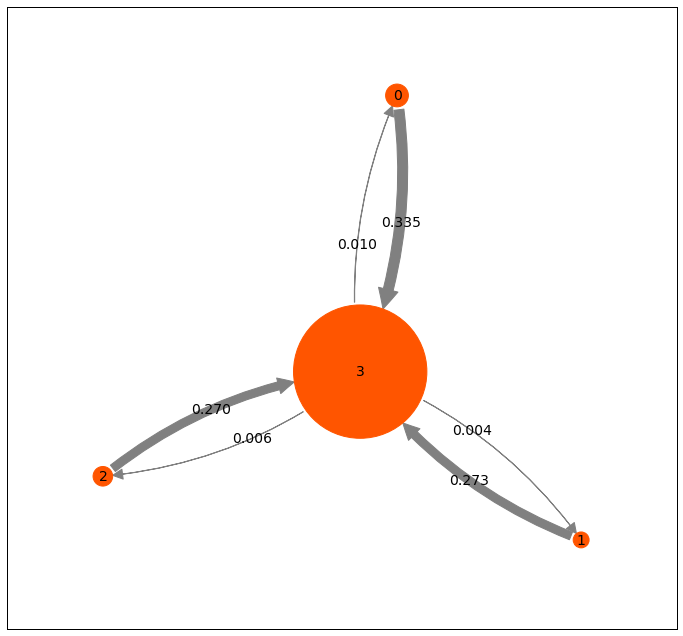

In [339]:
mpl.plot_markov_model(hmm, minflux=1e-03, arrow_label_format='%0.3f')
#mpl.plot_markov_model(hmm, pos=pos, minflux=1e-03)
#contourf(F.T, 100, extent=extent, zorder=0)
savefig('./figs/hmm_network.png')

In [287]:
membership=hmm.metastable_memberships  # get HMM memberships
# memberships over trajectory
mem1_all = np.hstack([membership[:,0][dtraj] for dtraj in M.discrete_trajectories_full])
mem2_all = np.hstack([membership[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
mem3_all = np.hstack([membership[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
mem4_all = np.hstack([membership[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

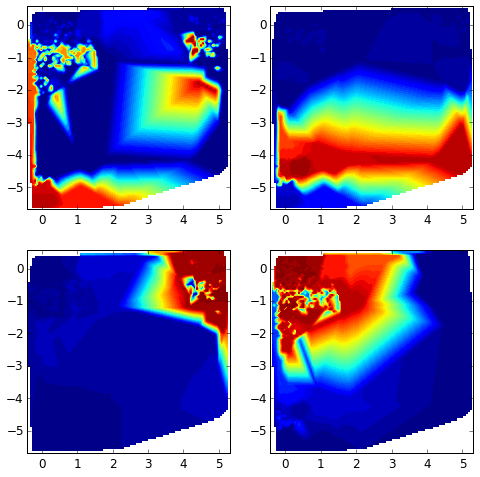

In [288]:
# FN: this looks weird. I need to check if this is converged.
# Or maybe something is wrong with the state assignment
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(221)
ax1 = mycontour(xall, yall, mem1_all, zlim=[0,1], method='linear', colorbar=False)

ax2 = plt.subplot(222)
ax2 = mycontour(xall, yall, mem2_all, zlim=[0,1], method='linear', colorbar=False)

ax3 = plt.subplot(223)
ax3 = mycontour(xall, yall, mem3_all, zlim=[0,1], method='linear', colorbar=False)

ax4 = plt.subplot(224)
ax4 = mycontour(xall, yall, mem4_all, zlim=[0,1], method='linear', colorbar=False)